In [5]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pickle

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz
import pydotplus
from IPython.display import Image 

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read model pickle files
with open('best_model.pickle', 'rb') as file:
    best_model = pickle.load(file)

In [3]:
# get training and test data
X_train = pd.read_csv('X_train.csv')
X_train.index = X_train['Unnamed: 0']
X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_train.index.name = ''

y_train = pd.read_csv('y_train.csv')
y_train.index = y_train['Unnamed: 0']
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_train.index.name = ''

X_test = pd.read_csv('X_test.csv')
X_test.index = X_test['Unnamed: 0']
X_test = X_test.drop(['Unnamed: 0'], axis=1)
X_test.index.name = ''

y_test = pd.read_csv('y_test.csv')
y_test.index = y_test['Unnamed: 0']
y_test = y_test.drop(['Unnamed: 0'], axis=1)
y_test.index.name = ''

In [4]:
# retrain best model on entire training set
final_model = best_model.fit(X_train, y_train)

## 1. Final model visualization

I visualized the final model `RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=70)` to make the mechanisms inside it more explicit. The outcome is 70 pdf files, which can all be found in the same repository.

In [7]:
# visualize final model random forest classifier
i = 0
for per_rf in final_model:
    dot_data = tree.export_graphviz(per_rf, out_file=None,
                                    feature_names=X_train.columns,
                                    class_names=['0','1'],
                                    filled=True, rounded=True,
                                    special_characters=True,
                                    precision=2)
    graph = pydotplus.graph_from_dot_data(dot_data)
    i = i + 1
    graph.write_pdf(str(i)+"DTTree.pdf")

## 2. Feature importance analysis

I performed feature importance analysis to figure out which features have higher tendency leading to heart disease based on the final model. I selected top 10 important features to make further comparision and discussion.

In [8]:
# perform feature importance analysis
def feature_importance_analysis(model, feat_names, nums):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        ranked_feats.append(feat_names[indices[i]])
    ranking = pd.DataFrame()
    ranking['Feature Index'] = indices
    ranking['Feature Name'] = ranked_feats
    ranking['Feature Importance'] = np.sort(importances)[::-1]
    display(ranking.iloc[:nums,:])
    
    ax = ranking[:nums][::-1].plot(x='Feature Name', y='Feature Importance', kind='barh', color='orange',
                                   figsize=(12,7), legend=False)
    ax.set_xlabel('Feature Importance', fontsize=12)
    plt.show()
    
    return

,Feature Index,Feature Name,Feature Importance
0,7,AgeCategory,0.333482
1,9,GenHealth,0.193598
2,6,DiffWalking,0.078499
3,3,Stroke,0.064018
4,4,PhysicalHealth,0.039357
5,24,Diabetic_Yes,0.038459
6,0,BMI,0.037481
7,22,Diabetic_No,0.031061
8,1,Smoking,0.023417
9,15,Sex_Male,0.023413


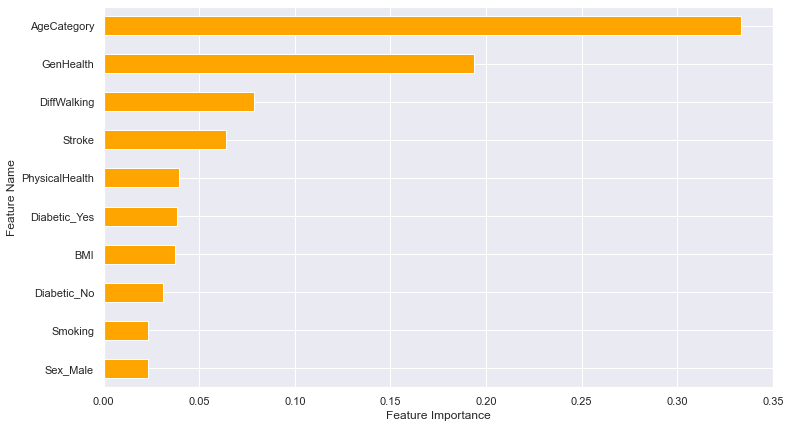

In [11]:
# find top 10 important features
feature_importance_analysis(final_model, X_train.columns, 10)

The top 10 important features are: AgeCategory (0.333) > GenHealth (0.194) > DiffWalking (0.078) > Stroke (0.064) > PhysicalHealth (0.039) > Diabetic_Yes (0.038) > BMI (0.037) > Diabetic_No (0.031) > Smoking (0.023) > Sex_Male (0.023).

It is worth noticing that the top 5 important features are AgeCategory, GenHealth, DiffWalking, Stroke and PhysicalHealth. Aging problem ranks the first, which is in line with other medical evidence and common sense. In other words, the probability of having a heart disease increases the greatest when respondents get older. As for GenHealth, the probability of having a heart disease increases significantly if respondents rate themselves as unhealthier. Hence, self-evaluation of the respondent, which might often be neglected in the past, should be taken into consideration more seriously. Having severe difficulty walking or climbing stairs is also recognized as an essential feature, which indicates such behavior could be a strong precursor to heart disease.

Stroke ranks the fourth and is more important compared with other diseases such as diabetes, asthma, kidney problems and skin cancer. One possible explaination is that stroke is also a kind of Cardiovascular Disease (CVD) just like heart disease, and there might be a higher probability in complications of CVD. PhysicalHealth ranks the fifth, hence the number of recent days that respondents considered themselves as unhealthy should also be taken into serious consideration like GenHealth.

## 3. Discussions & conclusions

To sum up,  `RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=70)` is chosen as the best among all of the classifiers, compared with other models which utilize Gradient Boosting, Bagging, Decision Tree and Adaptive Boosting techniques. For evaluation on test set, it has a high AUC of 0.842 and AP of 0.827.

The drawback of the project is that the false negative rate (0.191) is not as low as what we expected. Relatively inaccurate results like this may give patients a false sense of security, leading them to become lax about dieting and exercising. To deal with this, some future work needs to be done. For example, the adjustments could be: 1. use oversampling instead of undersampling to get more datapoints, which might benefit model training, tuning, evaluating and predicting. 2. perform analysis first to narrow down the number of variables (e.g. PCA), and select more proper features with heart disease to optimize the models.

For the insights, aging problem, self-evaluation, difficulty walking or climbing stairs, stroke and recent days assessment are found to be the top 5 important features for heart disease. This finding could educate doctors, nurses, researchers and potential patients to focus more on these factors and take precautions in advance.